In [2]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

import numpy as np
import matplotlib.pyplot as plt

from src.ulam.generate import generate_ulam_spiral, generate_prime_mask

%matplotlib inline


In [3]:
SIZE = 101  # must be odd

spiral = generate_ulam_spiral(SIZE)
prime_mask = generate_prime_mask(spiral)

spiral[:10, :10], prime_mask[:10, :10]


(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

(np.float64(-0.5), np.float64(100.5), np.float64(100.5), np.float64(-0.5))

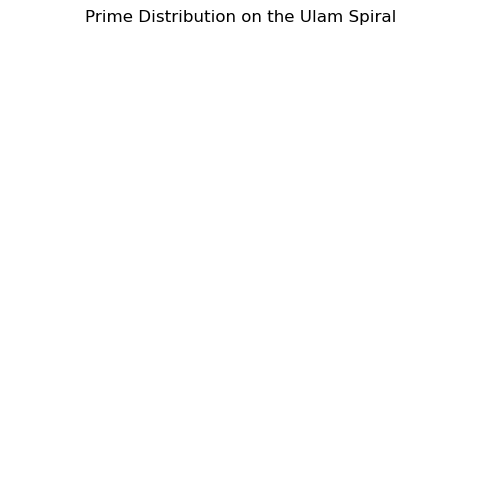

In [4]:
plt.figure(figsize=(6, 6))
plt.imshow(prime_mask, cmap="Greys")
plt.title("Prime Distribution on the Ulam Spiral")
plt.axis("off")


(np.float64(-0.5), np.float64(100.5), np.float64(100.5), np.float64(-0.5))

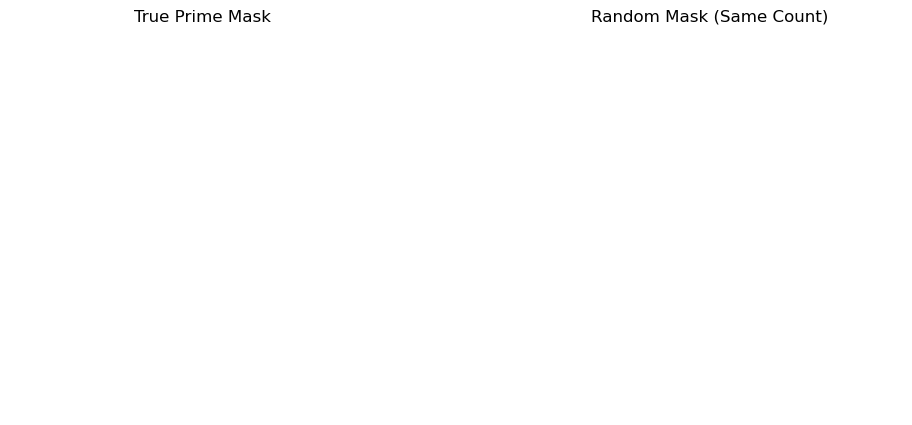

In [5]:
num_primes = np.sum(prime_mask)

random_mask = np.zeros_like(prime_mask).flatten()
random_mask[:num_primes] = 1
np.random.shuffle(random_mask)
random_mask = random_mask.reshape(prime_mask.shape)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(prime_mask, cmap="Greys")
plt.title("True Prime Mask")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(random_mask, cmap="Greys")
plt.title("Random Mask (Same Count)")
plt.axis("off")


(np.float64(-0.5), np.float64(100.5), np.float64(100.5), np.float64(-0.5))

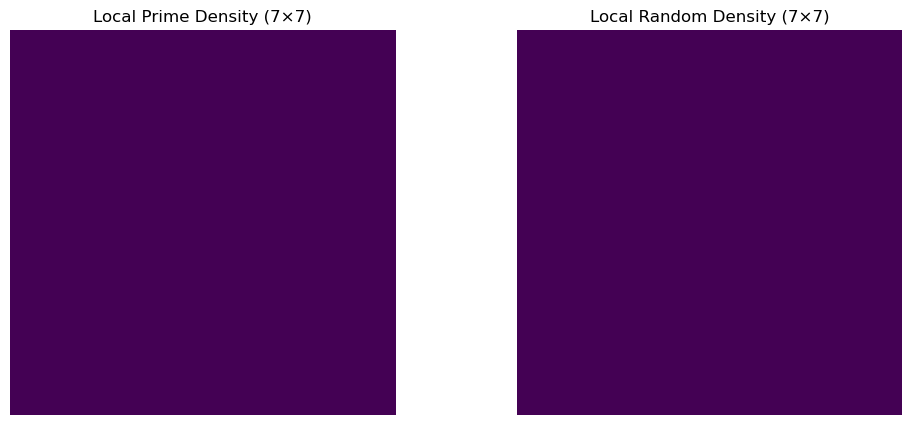

In [6]:
def local_density(mask, window_size=7):
    w = window_size // 2
    density_map = np.zeros_like(mask, dtype=float)

    for i in range(w, mask.shape[0] - w):
        for j in range(w, mask.shape[1] - w):
            window = mask[i-w:i+w+1, j-w:j+w+1]
            density_map[i, j] = np.mean(window)
    
    return density_map


prime_density = local_density(prime_mask, window_size=7)
random_density = local_density(random_mask, window_size=7)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(prime_density, cmap="viridis")
plt.title("Local Prime Density (7×7)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(random_density, cmap="viridis")
plt.title("Local Random Density (7×7)")
plt.axis("off")


### Reflection

1. What visible differences exist between the real density map and the random density map?

2. Which features look like they might be learnable, even if they are not causal?

3. Does the diagonal structure imply local predictability, or only global organisation?

4. Current hypothesis about local predictability of primes:
